# Introduction

k-Nearest-Neighbors (kNN) is a simple technique for classification. The idea behind
it is that similar data points should have the same class, at least most of the time.
This method is very intuitive and has proven itself in many domains including
recommendation systems, anomaly detection, image/text classification and more.

In what follows we present a detailed example of a multi-class classification objective. The dataset we use contains information collected by the US Geological Survey and the US Forest Service about wilderness areas in northern Colorado. The features are measurements like soil type, elevation, and distance to water, and the labels encode the type of trees - the forest cover type - for each location. The machine learning task is to predict the cover type in a given location using the features. Overall there are seven cover types.

The notebook has two sections. In the first, we use Amazon SageMaker's python SDK in order to train a kNN classifier in its simplest setting. We explain the components common to all Amazon SageMaker's algorithms including uploading data to Amazon S3, training a model, and setting up an endpoint for online inference. In the second section we dive deeper into the details of Amazon SageMaker kNN. We explain the different knobs (hyper-parameters) associated with it, and demonstrate how each setting can lead to a somewhat different accuracy and latency at inference time.

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.


# Part 1: Running kNN in 5 minutes

## Dataset

We're about to work with the UCI Machine Learning Repository Covertype  dataset [1]  ([covtype](https://archive.ics.uci.edu/ml/datasets/covertype)) (copyright Jock A. Blackard and Colorado State University). It's a labeled dataset where each entry describes a geographic area, and the label is a type of forest cover. There are 7 possible labels and we aim to solve the mult-class classification problem using kNN.
We begin by downloading the dataset from a S3 bucket and moving it to a temporary folder. It was originally downloaded from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz).

>[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [40]:
import boto3
##Setup
import sagemaker
import os
import pandas as pd
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemakerbankfraud-xgboost'

# Define IAM role

import re
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

# S3 bucket where the original covtype data is downloaded and stored.
s3 = boto3.client("s3")
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'preprocessed/preprocessed.csv')).download_file('preprocessed.csv')
data = pd.read_csv('preprocessed.csv')


In [41]:
display(data.isfraud.value_counts())

data = data.drop(data.columns[0],1)
prefix = 'sagemakerbankfraud-KNN'  ##reset prefix

0    6354407
1       8213
Name: isfraud, dtype: int64

## Pre-Processing the Data
Now that we have the raw data, let's process it. 
We'll first load the data into numpy arrays, and randomly split it into train and test with a 90/10 split.

In [42]:
import numpy as np
import os


train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, sec

In [43]:
train_data_labels = train_data.pop('isfraud')
validation_data_labels = validation_data.pop('isfraud')
test_data_labels = test_data.pop('isfraud')


train_data_features = train_data.iloc[:,0:]
validation_data_features = validation_data.iloc[:,0:]
test_data_features = test_data.iloc[:,0:]


train_data_labels_np = train_data_labels.values
validation_labels_np = validation_data_labels.values
test_labels_np = test_data_labels.values

train_data_features_np = train_data_features.values
validation_features_np = validation_data_features.values
test_features_np = test_data_features.values

## Upload to Amazon S3
Now, since typically the dataset will be large and located in Amazon S3, let's write the data to Amazon S3 in recordio-protobuf format. We first create an io buffer wrapping the data, next we upload it to Amazon S3. Notice that the choice of bucket and prefix should change for different users and different datasets

In [44]:
import io
import sagemaker.amazon.common as smac

print("train_features shape = ", train_data_features_np.shape)
print("train_labels shape = ", train_data_labels_np.shape)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_data_features_np, train_data_labels_np)
buf.seek(0)

train_features shape =  (4453834, 15)
train_labels shape =  (4453834,)


0

In [45]:
print("val_features shape = ", validation_features_np.shape)
print("val_labels shape = ", validation_labels_np.shape)

buf2 = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf2, validation_features_np, validation_labels_np)
buf2.seek(0)

val_features shape =  (1272524, 15)
val_labels shape =  (1272524,)


0

In [46]:
import boto3
import os
import sagemaker

bucket = sagemaker.Session().default_bucket()  # modify to your bucket name
prefix = 'sagemakerbankfraud-KNN'  ##reset prefix
key = "recordio-pb-data"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation", key)).upload_fileobj(buf2)
s3_validation_data = f"s3://{bucket}/{prefix}/validation/{key}"
print(f"uploaded validation data location: {s3_validation_data}")

uploaded training data location: s3://sagemaker-us-east-1-246778806733/sagemakerbankfraud-KNN/train/recordio-pb-data
uploaded validation data location: s3://sagemaker-us-east-1-246778806733/sagemakerbankfraud-KNN/validation/recordio-pb-data


It is also possible to provide test data. This way we can get an evaluation of the performance of the model from the training logs. In order to use this capability let's upload the test data to Amazon S3 as well

In [47]:
print(f"test_features shape = {test_features_np.shape}")
print(f"test_labels shape = {test_labels_np.shape}")

buf3 = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, test_features_np, test_labels_np)
buf3.seek(0)

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "test", key)).upload_fileobj(buf3)
s3_test_data = f"s3://{bucket}/{prefix}/test/{key}"
print(f"uploaded test data location: {s3_test_data}")

test_features shape = (636262, 15)
test_labels shape = (636262,)
uploaded test data location: s3://sagemaker-us-east-1-246778806733/sagemakerbankfraud-KNN/test/recordio-pb-data


## Training

We take a moment to explain at a high level, how Machine Learning training and prediction works in Amazon SageMaker. First, we need to train a model. This is a process that given a labeled dataset and hyper-parameters guiding the training process,  outputs a model. Once the training is done, we set up what is called an **endpoint**. An endpoint is a web service that given a request containing an unlabeled data point, or mini-batch of data points, returns a prediction(s).

In Amazon SageMaker the training is done via an object called an **estimator**. When setting up the estimator we specify the location (in Amazon S3) of the training data, the path (again in Amazon S3) to the output directory where the model will be serialized, generic hyper-parameters such as the machine type to use during the training process, and kNN-specific hyper-parameters such as the index type, etc. Once the estimator is initialized, we can call its **fit** method in order to do the actual training.

Now that we are ready for training, we start with a convenience function that starts a training job.

In [50]:
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

from sagemaker.amazon.amazon_estimator import get_image_uri


def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data):
    """
    Create an Estimator from the given hyperparams, fit to training data,
    and return a deployed predictor
    
    """
    ###bring in container artifact
    container = sagemaker.image_uris.retrieve("knn", boto3.Session().region_name)
    #display(container)
    # set up the estimator
    knn = sagemaker.estimator.Estimator(
        container,
        get_execution_role(),
        instance_count=1,
        instance_type="ml.m5.2xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    knn.set_hyperparameters(**hyperparams)

    # train a model. fit_input contains the locations of the train and test data
    fit_input = {"train": s3_train_data}
    if s3_test_data is not None:
        fit_input["test"] = s3_test_data
    knn.fit(fit_input)
    return knn

Now, we run the actual training job. For now, we stick to default parameters.

In [51]:
hyperparams = {"feature_dim": 15, "k": 2, "sample_size": 200000, "predictor_type": "classifier"}
output_path = f"s3://{bucket}/{prefix}/output"
knn_estimator = trained_estimator_from_hyperparams(
    s3_train_data, hyperparams, output_path, s3_test_data=s3_validation_data
)

2021-01-08 19:41:38 Starting - Starting the training job...
2021-01-08 19:42:01 Starting - Launching requested ML instancesProfilerReport-1610134898: InProgress
.........
2021-01-08 19:43:22 Starting - Preparing the instances for training...
2021-01-08 19:44:03 Downloading - Downloading input data...
2021-01-08 19:44:33 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/08/2021 19:44:37 INFO 140341247051584] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'feature_dim': u'auto', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[01/08/2021 19:44:37 INFO 14

[2021-01-08 19:44:48.742] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 9779, "num_examples": 891, "num_bytes": 730428776}
[01/08/2021 19:44:48 INFO 140341247051584] push reservoir to kv... 1 num_workers 0 rank
[01/08/2021 19:44:48 INFO 140341247051584] ...done (200000)
[01/08/2021 19:44:48 INFO 140341247051584] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 891, "sum": 891.0, "min": 891}, "Number of Batches Since Last Reset": {"count": 1, "max": 891, "sum": 891.0, "min": 891}, "Number of Records Since Last Reset": {"count": 1, "max": 4453834, "sum": 4453834.0, "min": 4453834}, "Total Batches Seen": {"count": 1, "max": 891, "sum": 891.0, "min": 891}, "Total Records Seen": {"count": 1, "max": 4453834, "sum": 4453834.0, "min": 4453834}, "Max Records Seen Between Resets": {"count": 1, "max": 4453834, "sum": 4453834.0, "min": 4453834}, "Reset Count": 

In [58]:
type(knn_estimator)

sagemaker.estimator.Estimator

Notice that we mentioned a test set in the training job. When a test set is provided the training job doesn't just produce a model but also applies it to the test set and reports the accuracy. In the logs you can view the accuracy of the model on the test set.

## Tuning

In [54]:
objective_metric_name = 'test:accuracy'

In [55]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'k': IntegerParameter(2, 6),
                            'sample_size': IntegerParameter(200000, 600000)
                        }

In [59]:
tuner = HyperparameterTuner(knn_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=6,
                            max_parallel_jobs=2,
                           strategy = 'Bayesian')

In [60]:
tuner.fit({'train': s3_train_data, 'test': s3_validation_data}, include_cls_metadata=False,wait=False)

In [61]:
tuner.strategy

'Bayesian'

In [62]:
#boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
#HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [64]:
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = 'knn-210108-1950'

In [88]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_maximize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Minimize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

6 training jobs have completed


In [89]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2021, 1, 8, 20, 6, 58, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:accuracy',
                                                 'Value': 0.9991434216499329},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 1, 8, 20, 15, 56, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:246778806733:training-job/knn-210108-1950-005-ea17314e',
 'TrainingJobName': 'knn-210108-1950-005-ea17314e',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2021, 1, 8, 20, 8, 51, tzinfo=tzlocal()),
 'TunedHyperParameters': {'k': '2', 'sample_size': '589260'}}


In [90]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 6
{'lowest': 0.9988306760787964, 'highest': 0.9991434216499329}


,k,sample_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,2.0,589260.0,knn-210108-1950-005-ea17314e,Completed,0.999143,2021-01-08 20:08:51+00:00,2021-01-08 20:15:56+00:00,425.0
0,2.0,600000.0,knn-210108-1950-006-ea589402,Completed,0.999139,2021-01-08 20:12:17+00:00,2021-01-08 20:19:19+00:00,422.0
2,2.0,593260.0,knn-210108-1950-004-5b12d467,Completed,0.999138,2021-01-08 20:02:21+00:00,2021-01-08 20:09:31+00:00,430.0
3,4.0,567173.0,knn-210108-1950-003-9c1814ee,Completed,0.999037,2021-01-08 19:59:17+00:00,2021-01-08 20:06:22+00:00,425.0
4,5.0,538789.0,knn-210108-1950-002-c07cfc54,Completed,0.999033,2021-01-08 19:53:12+00:00,2021-01-08 19:59:28+00:00,376.0
5,5.0,215626.0,knn-210108-1950-001-64ce9ec8,Completed,0.998831,2021-01-08 19:52:54+00:00,2021-01-08 19:56:28+00:00,214.0


## Setting up the endpoint


In [91]:
###get best model from tuner
best_model = tuning_job_result.get('BestTrainingJob',None)["TrainingJobName"]
print(best_model)

knn-210108-1950-005-ea17314e


In [93]:
%%time
import boto3
from time import gmtime, strftime

model_name = f"{best_model}-mod"
print(model_name)
container = sagemaker.image_uris.retrieve("knn", boto3.Session().region_name)

info = sage_client.describe_training_job(TrainingJobName=best_model)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": container, "ModelDataUrl": model_data}

create_model_response = sage_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

knn-210108-1950-005-ea17314e-mod
s3://sagemaker-us-east-1-246778806733/sagemakerbankfraud-KNN/output/knn-210108-1950-005-ea17314e/output/model.tar.gz
arn:aws:sagemaker:us-east-1:246778806733:model/knn-210108-1950-005-ea17314e-mod
CPU times: user 32.6 ms, sys: 0 ns, total: 32.6 ms
Wall time: 530 ms


In [100]:
###set up endpoint autoscaling feature
from time import strftime, gmtime
timestamp = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

model_name = model_name
endpoint_config_name = 'KNN-model-epc' +timestamp
endpoint_name = 'KNN-bankfraud'+timestamp

production_variants = [{
    'VariantName':'variant-1',
    'ModelName':model_name,
    'InstanceType':'ml.m5.xlarge',
    'InitialVariantWeight':1,
    'InitialInstanceCount':2,
    
}]

In [101]:
sage_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = production_variants)


{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:246778806733:endpoint-config/knn-model-epc2021-01-08-21-11-46',
 'ResponseMetadata': {'RequestId': '13f9885e-dd93-4e69-9d14-694a96746ec9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '13f9885e-dd93-4e69-9d14-694a96746ec9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Fri, 08 Jan 2021 21:11:47 GMT'},
  'RetryAttempts': 0}}

In [102]:
deployed = sage_client.create_endpoint(
    EndpointName = endpoint_name,
    EndpointConfigName = endpoint_config_name
)

deployed

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:246778806733:endpoint/knn-bankfraud2021-01-08-21-11-46',
 'ResponseMetadata': {'RequestId': '1b7aaef1-b9cd-4b2b-a912-1a1115a8846b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1b7aaef1-b9cd-4b2b-a912-1a1115a8846b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Fri, 08 Jan 2021 21:13:38 GMT'},
  'RetryAttempts': 0}}

In [103]:
#print(endpoint_name)
ResourceId='endpoint/'+endpoint_name+'/variant/variant-1'
print(ResourceId)

endpoint/KNN-bankfraud2021-01-08-21-11-46/variant/variant-1


In [104]:
appknn = boto3.client('application-autoscaling')

In [105]:
###register a policy once endpoint is created
appknn.register_scalable_target(
    ServiceNamespace ='sagemaker',
    ResourceId = ResourceId,
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
    MinCapacity=2,
    MaxCapacity=10)

{'ResponseMetadata': {'RequestId': '2b3e1223-c0d8-49e0-8a2c-8f518981635e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2b3e1223-c0d8-49e0-8a2c-8f518981635e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Fri, 08 Jan 2021 21:26:43 GMT'},
  'RetryAttempts': 0}}

## Inference

Now that we have our predictor, let's use it on our test dataset. The following code runs on the test dataset, computes the accuracy and the average latency. It splits up the data into 100 batches, each of size roughly 500. Then, each batch is given to the inference service to obtain predictions. Once we have all predictions, we compute their accuracy given the true labels of the test set.


In [146]:
###get test data in correct format to invoke endpoint to evaluate
##tested 1000 items

test_data_features
test_data_tail = test_data_features.head(2000)

    
test_data_tail.to_csv('test_data_tail.csv',header =False, index=False)


In [147]:
runtime_client = boto3.Session().client('runtime.sagemaker')

In [148]:
import time
import json
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

predictions = []

with open('test_data_tail.csv', 'r') as f:
    for row in f:
        print(".", sep=',', end='', flush=True)
        payload = row.rstrip('\n')
        response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType="text/csv",
                                       Accept='Accept',
                                       Body=payload)
        result = json.loads(response['Body'].read().decode())
        preds =  [r['predicted_label'] for r in result['predictions']]
        predictions.append(preds)
        time.sleep(0.5)

#Convert our predictions to a numpy array

                 
        
print("Done!")

Sending test traffic to the endpoint KNN-bankfraud2021-01-08-21-11-46. 
Please wait...
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,variant-1
Timestamp,
2021-01-08 23:33:00+00:00,48.0
2021-01-08 23:34:00+00:00,112.0
2021-01-08 23:35:00+00:00,114.0
2021-01-08 23:36:00+00:00,114.0
2021-01-08 23:37:00+00:00,114.0
2021-01-08 23:38:00+00:00,115.0
2021-01-08 23:39:00+00:00,114.0
2021-01-08 23:40:00+00:00,114.0
2021-01-08 23:41:00+00:00,114.0


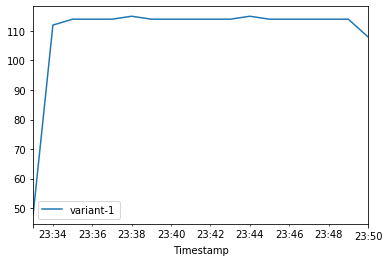

In [149]:
from datetime import datetime, timedelta
import time
import pandas as pd
cw = boto3.Session().client("cloudwatch")
variant = 'variant-1'

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(endpoint_name, 'variant-1', start_time, end_time)
    metrics_variant1.plot()
    return metrics_variant1

time.sleep(20) #let metrics catch up
plot_endpoint_metrics()

In [150]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

test_labels_np = test_data_labels.head(2000).to_numpy()

test_actuals=test_labels_np

test_actuals= pd.Series(test_actuals)


In [151]:
predictions

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],


In [152]:
#Convert our predictions to a numpy array
preds = [i[0] for i in predictions]
preds = pd.Series(preds)
print(preds)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1995    0.0
1996    0.0
1997    0.0
1998    0.0
1999    0.0
Length: 2000, dtype: float64


In [153]:
###set up confusion matrix
df_confusion = pd.crosstab(index=test_actuals, columns=preds, rownames=['actuals'], colnames=['predictions'])
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

predictions,0.0,1.0
actuals,,
0,1.000000,0.000000
1,0.002508,0.166667


Accuracy: 0.9975
Precision: 1.0
Recall: 0.16666666666666666
F1 Score: 0.2857142857142857
AUC is 0.5833


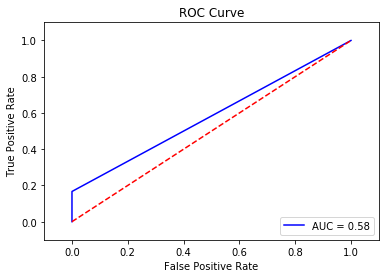

In [154]:
# Calculate accuracy
accuracy = sum(preds == test_actuals) / len(test_actuals)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = sum(preds[preds == 1] == test_actuals[preds == 1]) / len(preds[preds == 1])
print(f'Precision: {precision}')

# Calculate recall
recall = sum(preds[preds == 1] == test_actuals[preds == 1]) / len(test_actuals[test_actuals == 1])
print(f'Recall: {recall}')

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

# Calculate AUC
auc = round(roc_auc_score(test_actuals, preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(test_actuals, preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

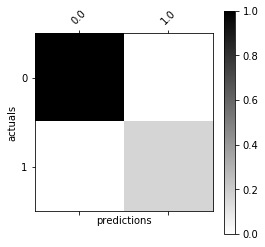

In [155]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

## Deleting the endpoint

We're now done with the example except a final clean-up act. By setting up the endpoint we started a machine in the cloud and as long as it's not deleted the machine is still up and we are paying for it. Once the endpoint is no longer necessary, we delete it. The following code does exactly that.

In [ ]:
####to save cost and delete since this is a demo-project
app.delete_scaling_policy(
    PolicyName=policy_name,
    ServiceNamespace = 'sagemaker',
    ResourceId = 'endpoint/xgboost-bankfraud/variant/variant-1',
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
)
sm.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name)